In [1]:
from dotenv import load_dotenv
load_dotenv()

from langchain_anthropic import ChatAnthropic
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA, ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate
import requests
import os
from typing import List, Dict, Tuple
from dataclasses import dataclass
import joblib
from pathlib import Path
import re
from nltk.corpus import stopwords
import numpy as np


Incident Category Classifier Agent


In [2]:
@dataclass
class EnhancedAnalysisResult:
    impact_analysis: str
    mitigation_strategies: str
    source_documents: List[str]
    similarity_scores: List[float]
    incident_categories: List[str]
    category_probabilities: Dict[str, float]


In [3]:
class MaritimeClassifier:
    def __init__(self, models_dir: str = 'models'):
        self.models_dir = Path(models_dir)
        self.categories = {
            'model_l1': "level 1: Port criminal activities",
            'model_l2': "level 2: Port congestion",
            'model_l3': "level 3: Maritime cargo and ship detainment",
            'model_l4': "level 4: Maritime environmental impacts and pollution",
            'model_l5': "level 5: Maritime piracy or terrorism risk",
            'model_l6': "level 6: Maritime",
            'model_l7': "level 7: Maritime unstable regulatory and political environment",
            'model_l8': "level 8: Vessel delay",
            'model_l9': "level 9: Inland transportation risks",
            'model_l10': "level 10: Maritime natural extreme events and extreme weather",
            'model_l11': "level 11: Cargo damage and loss"
        }
        self.load_models()
        
    def load_models(self):
        """Load all models and vectorizer"""
        try:
            self.vectorizer = joblib.load(self.models_dir / 'vectorizer.joblib')
            self.models = {}
            for model_name in self.categories.keys():
                self.models[model_name] = joblib.load(self.models_dir / f'{model_name}.joblib')
            print("All classification models loaded successfully")
        except Exception as e:
            print(f"Error loading models: {e}")
            raise
    
    def clean_text(self, text: str) -> str:
        """Clean text using stopwords"""
        stop_words = set(stopwords.words('english'))
        text = re.sub(r'\W', ' ', text)
        text = text.lower()
        tokens = [word for word in text.split() if word not in stop_words]
        return ' '.join(tokens)
    
    def predict(self, text: str, threshold: float = 0.5) -> Tuple[List[str], Dict[str, float]]:
        """Predict incident categories"""
        clean_input = self.clean_text(text)
        input_vec = self.vectorizer.transform([clean_input])
        
        predictions = []
        probabilities = {}
        
        for model_name, model in self.models.items():
            prob = model.predict_proba(input_vec)[0][1]
            probabilities[self.categories[model_name]] = prob
            
            if prob >= threshold:
                predictions.append(self.categories[model_name])
        
        return predictions, probabilities


Severity Assessment Classifier

In [17]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Tuple, Dict, Union
import logging
from anthropic import Anthropic
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import os
from dotenv import load_dotenv
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
import json

class MaritimeSeverityClassifier:
    def __init__(self, 
                 model_name: str = 'all-MiniLM-L6-v2', 
                 top_k: int = 5,
                 thresholds: Dict[str, float] = None):
        """
        Initialize the Maritime Severity Classifier
        
        Args:
            model_name: The sentence transformer model to use for embeddings
            top_k: Number of similar incidents to consider
            thresholds: Custom thresholds for severity classification
        """
        # Load environment variables
        load_dotenv()
        
        # Initialize models and clients
        self.model = SentenceTransformer(model_name)
        # Alternative: Use Langchain's HuggingFaceEmbeddings for compatibility
        self.langchain_embeddings = HuggingFaceEmbeddings(model_name=model_name)
        
        self.top_k = top_k
        self.data = None
        self.embeddings = None
        self.client = Anthropic(api_key=os.getenv('ANTHROPIC_API_KEY'))
        self.thresholds = thresholds or {'minor': 1.7, 'moderate': 2.3}
        self.severity_mapping = {
            'minor': 1,
            'moderate': 2,
            'severe': 3
        }
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def create_langchain_document(self, classification_result: Dict) -> Document:
        """
        Convert classification result to Langchain Document format
        
        Args:
            classification_result: Result from classify_severity
            
        Returns:
            Langchain Document with metadata
        """
        return Document(
            page_content=classification_result['evidence']['llm_reasoning'] if classification_result['evidence']['llm_reasoning'] else "",
            metadata={
                'severity': classification_result['classification']['severity'],
                'confidence': classification_result['classification']['confidence'],
                'key_factors': classification_result['classification']['key_factors'],
                'similarity_score': classification_result['evidence']['similarity_score'],
                'similar_incidents': [
                    {
                        'headline': incident['headline'],
                        'severity': incident['severity'],
                        'similarity': incident['similarity']
                    }
                    for incident in classification_result['evidence']['similar_incidents'][:3]  # Top 3 for brevity
                ]
            }
        )

    def process_langchain_input(self, document: Union[Document, str]) -> str:
        """
        Process input that might come from Langchain pipeline
        
        Args:
            document: Either a Langchain Document or raw text
            
        Returns:
            Extracted text for classification
        """
        if isinstance(document, Document):
            return document.page_content
        return document

    def get_langchain_embeddings(self, text: str) -> List[float]:
        """
        Get embeddings using Langchain's embedding interface
        
        Args:
            text: Text to embed
            
        Returns:
            Embedding vector
        """
        return self.langchain_embeddings.embed_query(text)

    def classify_severity(self, 
                     input_text: Union[str, Document], 
                     return_langchain_doc: bool = False) -> Union[Dict, Document]:
        """
        Classify severity of a maritime incident
        
        Args:
            input_text: Either raw text or a Langchain Document
            return_langchain_doc: Whether to return result as a Langchain Document
            
        Returns:
            Classification result in specified format
        """
        # Process input
        text = self.process_langchain_input(input_text)
        
        # Get similarity-based classification first
        similar_incidents = self.find_similar_incidents(text)
        similarity_score = self._calculate_severity_score(text)
        similarity_based_severity = self._score_to_severity(similarity_score)
        
        # Try LLM classification
        llm_classification = self.get_llm_severity_classification(text, similar_incidents)
        
        similar_incidents_info = [
            {
                'index': idx,
                'similarity': sim,
                'severity': sev,
                'headline': self.data.iloc[idx]['Headline'],
                'description': self.data.iloc[idx]['Description']
            }
            for idx, sim, sev in similar_incidents
        ]
        
        # If LLM classification failed, create a fallback classification based on similarity
        if llm_classification is None:
            self.logger.warning("LLM classification failed, using similarity-based classification")
            llm_classification = {
                'severity': similarity_based_severity,
                'reasoning': f"Classification based on similarity to historical incidents (score: {similarity_score:.2f})",
                'key_factors': [f"Similar to {len(similar_incidents)} historical incidents"],
                'confidence': 'MEDIUM'
            }
        
        result = {
            'classification': {
                'severity': llm_classification['severity'],
                'confidence': llm_classification['confidence'],
                'key_factors': llm_classification['key_factors']
            },
            'evidence': {
                'similar_incidents': similar_incidents_info,
                'similarity_score': similarity_score,
                'similarity_based_severity': similarity_based_severity,
                'llm_reasoning': llm_classification['reasoning']
            },
            'metadata': {
                'thresholds_used': self.thresholds,
                'model_version': 'claude-3-5-haiku-20241022',
                'embedding_model': 'all-MiniLM-L6-v2',
                'classification_method': 'llm' if llm_classification else 'similarity'
            }
        }
        
        # Return in requested format
        if return_langchain_doc:
            return self.create_langchain_document(result)
        return result

    def batch_classify(self, 
                      texts: List[Union[str, Document]], 
                      return_langchain_docs: bool = False) -> List[Union[Dict, Document]]:
        """
        Classify multiple incidents
        
        Args:
            texts: List of texts or Langchain Documents
            return_langchain_docs: Whether to return results as Langchain Documents
            
        Returns:
            List of classification results in specified format
        """
        return [
            self.classify_severity(text, return_langchain_doc=return_langchain_docs) 
            for text in texts
        ]


    def load_and_prepare_data(self, csv_path: str) -> None:
        """
        Load and prepare the historical incident data
        
        Args:
            csv_path: Path to the CSV file containing historical incidents
        """
        try:
            self.data = pd.read_csv(csv_path)
            # Combine headline and description for better context
            self.data['combined_text'] = self.data['Headline'] + ' ' + self.data['Description'].fillna('')
            # Create embeddings for all historical incidents
            self.embeddings = self.model.encode(self.data['combined_text'].tolist(), show_progress_bar=True)
            self.logger.info(f"Loaded {len(self.data)} incidents and created embeddings")
        except Exception as e:
            self.logger.error(f"Error loading data: {str(e)}")
            raise

    def find_similar_incidents(self, text: str) -> List[Tuple[int, float, str]]:
        """
        Find similar historical incidents for a given text
        
        Args:
            text: The incident text to classify
            
        Returns:
            List of tuples containing (index, similarity_score, severity)
        """
        # Create embedding for the input text
        text_embedding = self.model.encode([text])
        
        # Calculate similarity with all historical incidents
        similarities = cosine_similarity(text_embedding, self.embeddings)[0]
        
        # Get top_k similar incidents
        top_indices = np.argsort(similarities)[-self.top_k:][::-1]
        
        similar_incidents = [
            (idx, similarities[idx], self.data.iloc[idx]['Severity']) 
            for idx in top_indices
        ]
        
        return similar_incidents

    def calculate_class_weights(self) -> Dict[str, float]:
        """Calculate balanced class weights"""
        from sklearn.utils.class_weight import compute_class_weight
        import numpy as np
        
        severities = self.data['Severity'].str.lower()
        weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(severities),
            y=severities
        )
        return dict(zip(np.unique(severities), weights))

    def _calculate_severity_score(self, text: str) -> float:
        """Calculate weighted severity score based on similar incidents"""
        similar_incidents = self.find_similar_incidents(text)
        total_weight = 0
        weighted_score = 0
        
        # Get class weights
        class_weights = self.calculate_class_weights()
        
        for _, similarity, severity in similar_incidents:
            # Apply both similarity weight and class balance weight
            class_weight = class_weights.get(severity.lower(), 1.0)
            weight = similarity * class_weight
            severity_value = self.severity_mapping.get(severity.lower(), 0)
            weighted_score += weight * severity_value
            total_weight += weight
        
        return weighted_score / total_weight if total_weight > 0 else 0

    def _score_to_severity(self, score: float, thresholds: Dict[str, float] = None) -> str:
        """
        Convert numerical score to severity category
        
        Args:
            score: Numerical severity score
            thresholds: Optional custom thresholds
            
        Returns:
            Severity category (minor, moderate, or severe)
        """
        thresholds = thresholds or self.thresholds
        if score <= thresholds['minor']:
            return 'minor'
        elif score <= thresholds['moderate']:
            return 'moderate'
        return 'severe'

    
    def get_llm_severity_classification(self, text: str, similar_incidents: List[Tuple[int, float, str]]) -> Dict[str, any]:
        """Enhanced LLM classification with better prompting and analysis"""
        # Calculate class distribution
        severity_counts = self.data['Severity'].str.lower().value_counts()
        class_dist = {k: v/len(self.data) for k, v in severity_counts.items()}
        
        similar_incidents_text = "\n".join([
            f"Similar incident {i+1} (similarity: {sim:.2f}):\n"
            f"Headline: {self.data.iloc[idx]['Headline']}\n"
            f"Description: {self.data.iloc[idx]['Description']}\n"
            f"Severity: {sev}\n"
            for i, (idx, sim, sev) in enumerate(similar_incidents)
        ])

        prompt = f"""You are a maritime incident severity classifier. Analyze this incident carefully considering the following context:

    1. Current class distribution in our dataset:
    - Minor incidents: {class_dist.get('minor', 0):.1%}
    - Moderate incidents: {class_dist.get('moderate', 0):.1%}
    - Severe incidents: {class_dist.get('severe', 0):.1%}

    2. Severity Guidelines:
    - MINOR: Limited impact, no injuries, minimal disruption
    - MODERATE: Significant disruption, potential safety concerns, recoverable damage
    - SEVERE: Major casualties, extensive damage, significant environmental impact, or long-term disruption

    Incident to classify: important
    {text}

    Similar historical incidents for reference:
    {similar_incidents_text}

    Provide a balanced analysis in JSON format:
    {{
        "severity": "MINOR/MODERATE/SEVERE",
        "reasoning": "Step-by-step analysis considering incident details, historical patterns, and severity guidelines",
        "key_factors": ["List of specific factors that influenced the decision"],
        "confidence": "HIGH/MEDIUM/LOW",
        "uncertainty_factors": ["List of any uncertainties that might affect classification"]
    }}

    Important:
    1. Consider the class distribution but don't let it bias your judgment
    2. Consider the similar historical incidents 
    2. Use HIGH confidence only if evidence is very clear
    3. Be particularly careful with SEVERE classifications - require strong evidence
    4. Consider both direct impacts and potential consequences
    5. Make sure the output is strictly in JSON format
    6. reasoning must be a detailed explanation  
    7. key_factors must be a list of strings
    8. Do not include any explanatory text outside the JSON object   
    9. Do not use newlines in the reasoning text"""

        try:
            response = self.client.messages.create(
                model="claude-3-5-haiku-20241022",  # Using more capable model
                max_tokens=2000,
                temperature=0.3,
                messages=[{"role": "user", "content": prompt}]
            )
            
            llm_analysis = json.loads(response.content[0].text)
            
            # Adjust confidence based on uncertainty factors
            if 'uncertainty_factors' in llm_analysis and len(llm_analysis['uncertainty_factors']) > 2:
                llm_analysis['confidence'] = 'MEDIUM'
            
            return {
                'severity': llm_analysis['severity'].lower(),
                'reasoning': llm_analysis['reasoning'],
                'key_factors': llm_analysis['key_factors'],
                'confidence': llm_analysis['confidence'],
                'uncertainty_factors': llm_analysis.get('uncertainty_factors', []),
                'full_response': llm_analysis
            }
            
        except Exception as e:
            self.logger.error(f"Error in LLM classification: {str(e)}")
            return None
    def optimize_thresholds_smart(self) -> Dict[str, float]:
        """
        Smart threshold optimization using score distribution and binary search
        """
        import numpy as np
        from sklearn.metrics import f1_score
        
        print("Calculating severity scores...")
        all_scores = []
        all_true_labels = []
        
        # Calculate all scores once
        for _, row in self.data.iterrows():
            score = self._calculate_severity_score(row['combined_text'])
            all_scores.append(score)
            all_true_labels.append(row['Severity'].lower())
        
        all_scores = np.array(all_scores)
        all_true_labels = np.array(all_true_labels)
        
        # Get score statistics for each class
        score_stats = {}
        for severity in ['minor', 'moderate', 'severe']:
            mask = all_true_labels == severity
            if any(mask):
                class_scores = all_scores[mask]
                score_stats[severity] = {
                    'mean': np.mean(class_scores),
                    'std': np.std(class_scores),
                    'min': np.min(class_scores),
                    'max': np.max(class_scores)
                }
                print(f"\n{severity.upper()} scores:")
                print(f"Mean: {score_stats[severity]['mean']:.2f}")
                print(f"Std: {score_stats[severity]['std']:.2f}")
                print(f"Range: [{score_stats[severity]['min']:.2f}, {score_stats[severity]['max']:.2f}]")
        
        # Generate smart threshold ranges based on score distribution
        minor_mean = score_stats['minor']['mean']
        moderate_mean = score_stats['moderate']['mean']
        severe_mean = score_stats['severe']['mean']
        
        # Create focused ranges around class boundaries
        minor_thresholds = np.linspace(
            minor_mean - 0.2,
            moderate_mean + 0.2,
            5  # 5 values to try
        )
        
        moderate_thresholds = np.linspace(
            moderate_mean - 0.2,
            severe_mean + 0.2,
            5  # 5 values to try
        )
        
        print("\nTesting threshold combinations...")
        best_score = 0
        best_thresholds = self.thresholds.copy()
        best_metrics = None
        
        total_combinations = len(minor_thresholds) * len(moderate_thresholds)
        current_combination = 0
        
        for minor_thresh in minor_thresholds:
            for mod_thresh in moderate_thresholds:
                current_combination += 1
                if minor_thresh >= mod_thresh:
                    continue  # Skip invalid combinations
                    
                print(f"\rProgress: {current_combination}/{total_combinations} combinations", end='')
                
                predictions = []
                for score in all_scores:
                    if score <= minor_thresh:
                        pred = 'minor'
                    elif score <= mod_thresh:
                        pred = 'moderate'
                    else:
                        pred = 'severe'
                    predictions.append(pred)
                
                # Calculate balanced metrics
                f1_scores = f1_score(all_true_labels, predictions, 
                                average=None, 
                                labels=['minor', 'moderate', 'severe'])
                
                # Use macro average (unweighted mean of per-class scores)
                avg_score = np.mean(f1_scores)
                
                if avg_score > best_score:
                    best_score = avg_score
                    best_thresholds = {'minor': minor_thresh, 'moderate': mod_thresh}
                    
                    # Store detailed metrics
                    from sklearn.metrics import classification_report
                    best_metrics = classification_report(
                        all_true_labels, 
                        predictions,
                        output_dict=True
                    )
        
        print("\n\nOptimization complete!")
        print(f"Best thresholds: {best_thresholds}")
        print("\nPer-class performance with best thresholds:")
        for severity in ['minor', 'moderate', 'severe']:
            metrics = best_metrics[severity]
            print(f"\n{severity.upper()}:")
            print(f"Precision: {metrics['precision']:.3f}")
            print(f"Recall: {metrics['recall']:.3f}")
            print(f"F1-score: {metrics['f1-score']:.3f}")
            print(f"Support: {metrics['support']}")
        
        # Visualize the results
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
            
            plt.figure(figsize=(12, 6))
            
            # Plot score distributions
            for severity in ['minor', 'moderate', 'severe']:
                mask = all_true_labels == severity
                if any(mask):
                    sns.kdeplot(all_scores[mask], label=severity)
            
            # Add threshold lines
            plt.axvline(best_thresholds['minor'], color='g', linestyle='--', 
                    label='Minor threshold')
            plt.axvline(best_thresholds['moderate'], color='r', linestyle='--', 
                    label='Moderate threshold')
            
            plt.title('Score Distribution and Optimal Thresholds')
            plt.xlabel('Severity Score')
            plt.ylabel('Density')
            plt.legend()
            plt.show()
            
        except ImportError:
            print("Matplotlib not available for visualization")
        
        return best_thresholds
    def optimize_thresholds_fast(self) -> Dict[str, float]:
        """
        Optimize classification thresholds using a faster approach
        """
        import numpy as np
        from sklearn.model_selection import KFold
        
        # Use fewer threshold values to try
        minor_thresholds = np.array([1.3, 1.5, 1.7])  # 3 values instead of 6
        moderate_thresholds = np.array([2.3, 2.5, 2.7])  # 3 values instead of 6
        
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        best_thresholds = self.thresholds.copy()
        best_score = 0
        
        # Pre-calculate all severity scores to avoid redundant computation
        print("Calculating severity scores...")
        all_scores = []
        all_true_labels = []
        
        for _, row in self.data.iterrows():
            score = self._calculate_severity_score(row['combined_text'])
            all_scores.append(score)
            all_true_labels.append(row['Severity'].lower())
        
        all_scores = np.array(all_scores)
        all_true_labels = np.array(all_true_labels)
        
        print("Testing threshold combinations...")
        # Try different threshold combinations
        for minor_thresh in minor_thresholds:
            for mod_thresh in moderate_thresholds:
                temp_thresholds = {'minor': minor_thresh, 'moderate': mod_thresh}
                cv_scores = []
                
                # For each fold
                for train_idx, val_idx in kf.split(all_scores):
                    val_scores = all_scores[val_idx]
                    val_labels = all_true_labels[val_idx]
                    
                    # Predict using thresholds
                    predictions = []
                    for score in val_scores:
                        if score <= minor_thresh:
                            pred = 'minor'
                        elif score <= mod_thresh:
                            pred = 'moderate'
                        else:
                            pred = 'severe'
                        predictions.append(pred)
                    
                    # Calculate accuracy for this fold
                    accuracy = np.mean(np.array(predictions) == val_labels)
                    cv_scores.append(accuracy)
                
                # Average score across folds
                avg_score = np.mean(cv_scores)
                if avg_score > best_score:
                    best_score = avg_score
                    best_thresholds = temp_thresholds.copy()
                    print(f"New best thresholds found: {best_thresholds} (accuracy: {avg_score:.3f})")
        
        print(f"\nOptimization complete!")
        print(f"Best thresholds: {best_thresholds}")
        print(f"Best cross-validation accuracy: {best_score:.3f}")
        
        return best_thresholds
    def evaluate_thresholds(self, thresholds: Dict[str, float], plot: bool = True) -> Dict:
        """
        Evaluate a set of thresholds and optionally plot the results
        """
        # Calculate scores and predictions
        scores = []
        predictions = []
        true_labels = []
        
        for _, row in self.data.iterrows():
            score = self._calculate_severity_score(row['combined_text'])
            scores.append(score)
            
            # Get prediction using these thresholds
            if score <= thresholds['minor']:
                pred = 'minor'
            elif score <= thresholds['moderate']:
                pred = 'moderate'
            else:
                pred = 'severe'
            predictions.append(pred)
            true_labels.append(row['Severity'].lower())
        
        # Calculate metrics
        from sklearn.metrics import classification_report, confusion_matrix
        import numpy as np
        
        metrics = classification_report(true_labels, predictions, output_dict=True)
        conf_matrix = confusion_matrix(true_labels, predictions, 
                                    labels=['minor', 'moderate', 'severe'])
        
        # Optionally plot results
        if plot:
            import matplotlib.pyplot as plt
            import seaborn as sns
            
            # Plot confusion matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(conf_matrix, 
                    annot=True, 
                    fmt='d',
                    xticklabels=['minor', 'moderate', 'severe'],
                    yticklabels=['minor', 'moderate', 'severe'])
            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            
            # Plot score distribution by true severity
            plt.figure(figsize=(10, 6))
            for severity in ['minor', 'moderate', 'severe']:
                mask = np.array(true_labels) == severity
                if any(mask):
                    sns.kdeplot(np.array(scores)[mask], label=severity)
            plt.axvline(thresholds['minor'], color='g', linestyle='--', 
                    label='Minor threshold')
            plt.axvline(thresholds['moderate'], color='r', linestyle='--', 
                    label='Moderate threshold')
            plt.title('Score Distribution by Severity')
            plt.xlabel('Severity Score')
            plt.legend()
            plt.show()
        
        return {
            'metrics': metrics,
            'confusion_matrix': conf_matrix,
            'scores': scores,
            'predictions': predictions,
            'true_labels': true_labels
        }
    
    def evaluate_performance(self, test_data: pd.DataFrame = None) -> Dict[str, any]:
        """
        Evaluate classifier performance on test data with proper None handling
        """
        if test_data is None:
            _, test_data = train_test_split(self.data, test_size=0.2, random_state=42)
        
        # Validate required columns
        required_columns = ['Headline', 'Description', 'Severity']
        if not all(col in test_data.columns for col in required_columns):
            raise ValueError(f"Test data must contain columns: {required_columns}")
        
        predictions = []
        true_labels = []
        detailed_results = []
        
        for idx, row in test_data.iterrows():
            try:
                # Combine headline and description
                incident_text = f"{row['Headline']} {row['Description']}"
                
                # Get classification result
                result = self.classify_severity(incident_text)
                
                # Safely get values with defaults
                predicted_severity = result['classification']['severity']
                true_severity = row['Severity'].lower()
                
                predictions.append(predicted_severity)
                true_labels.append(true_severity)
                
                # Store detailed result with safe gets
                detailed_results.append({
                    'index': idx,
                    'true_severity': true_severity,
                    'predicted_severity': predicted_severity,
                    'confidence': result['classification'].get('confidence', 'N/A'),
                    'similarity_score': result['evidence'].get('similarity_score', 0.0),
                    'reasoning': result['evidence'].get('llm_reasoning'),
                    'key_factors': result['classification'].get('key_factors', []),
                    'correct': predicted_severity == true_severity
                })
                
            except Exception as e:
                self.logger.error(f"Error processing incident {idx}: {str(e)}")
                continue
        
        # Calculate metrics as before
        metrics = classification_report(true_labels, predictions, output_dict=True)
        
        # Calculate confusion matrix
        from sklearn.metrics import confusion_matrix
        import numpy as np
        
        labels = sorted(list(set(true_labels + predictions)))
        conf_matrix = confusion_matrix(true_labels, predictions, labels=labels)
        
        # Calculate severity accuracy
        severity_accuracy = {}
        for severity in set(true_labels):
            severity_mask = np.array(true_labels) == severity
            correct = np.array(predictions)[severity_mask] == severity
            severity_accuracy[severity] = {
                'accuracy': float(correct.mean()),  # Convert to float for JSON serialization
                'total_cases': int(sum(severity_mask)),
                'correct_predictions': int(sum(correct))
            }
        
        # Safe confidence analysis
        confidence_analysis = {
            'correct_predictions_avg_confidence': float(np.mean([
                1 if r.get('confidence') == 'HIGH' else 0
                for r in detailed_results 
                if r['correct']
            ])),
            'incorrect_predictions_avg_confidence': float(np.mean([
                1 if r.get('confidence') == 'HIGH' else 0
                for r in detailed_results 
                if not r['correct']
            ]))
        }
        
        return {
            'overall_metrics': metrics,
            'confusion_matrix': {
                'matrix': conf_matrix.tolist(),
                'labels': labels
            },
            'severity_accuracy': severity_accuracy,
            'confidence_analysis': confidence_analysis,
            'error_analysis': [r for r in detailed_results if not r['correct']],
            'thresholds': self.thresholds,
            'sample_size': len(test_data),
            'detailed_results': detailed_results
        }
    def prepare_train_test_split(self, test_size: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Prepare a stratified train-test split of the data
        
        Args:
            test_size: Proportion of data to use for testing
            
        Returns:
            Tuple of (train_df, test_df)
        """
        from sklearn.model_selection import train_test_split
        
        # Print original distribution
        print("\nOriginal Data Distribution:")
        original_dist = self.data['Severity'].value_counts()
        for severity, count in original_dist.items():
            print(f"{severity}: {count} ({count/len(self.data):.1%})")
        
        # Perform stratified split
        train_df, test_df = train_test_split(
            self.data,
            test_size=test_size,
            stratify=self.data['Severity'],
            random_state=42
        )
        
        # Print distributions after split
        print("\nTraining Data Distribution:")
        train_dist = train_df['Severity'].value_counts()
        for severity, count in train_dist.items():
            print(f"{severity}: {count} ({count/len(train_df):.1%})")
            
        print("\nTest Data Distribution:")
        test_dist = test_df['Severity'].value_counts()
        for severity, count in test_dist.items():
            print(f"{severity}: {count} ({count/len(test_df):.1%})")
        
        return train_df, test_df

    def train_and_evaluate(self, train_df: pd.DataFrame, test_df: pd.DataFrame) -> Dict:
        """
        Train on training data and evaluate on test data
        """
        # Store original data
        original_data = self.data
        
        # Train (set embeddings using training data)
        print("\nTraining classifier...")
        self.data = train_df
        self.embeddings = self.model.encode(
            train_df['combined_text'].tolist(), 
            show_progress_bar=True
        )
        
        # Try different thresholds on training data
        print("\nOptimizing thresholds on training data...")
        original_thresholds = self.thresholds.copy()
        # optimal_thresholds = self.optimize_thresholds_fast()
        optimal_thresholds = self.optimize_thresholds_smart()
        
        
        # Evaluate on test data
        print("\nEvaluating on test data...")
        results = {
            'original': self._evaluate_with_thresholds(test_df, original_thresholds),
            'optimized': self._evaluate_with_thresholds(test_df, optimal_thresholds)
        }
        
        # Restore original data
        self.data = original_data
        self.embeddings = self.model.encode(
            original_data['combined_text'].tolist(), 
            show_progress_bar=True
        )
        
        return results

    def _evaluate_with_thresholds(self, test_df: pd.DataFrame, thresholds: Dict[str, float]) -> Dict:
        """
        Evaluate performance using specific thresholds
        """
        predictions = []
        true_labels = []
        
        self.thresholds = thresholds
        
        for _, row in test_df.iterrows():
            # Get prediction
            result = self.classify_severity(row['combined_text'])
            predictions.append(result['classification']['severity'])
            true_labels.append(row['Severity'].lower())
        
        # Calculate metrics
        from sklearn.metrics import classification_report, confusion_matrix
        
        metrics = classification_report(true_labels, predictions, output_dict=True)
        conf_matrix = confusion_matrix(
            true_labels, predictions,
            labels=['minor', 'moderate', 'severe']
        )
        
        return {
            'metrics': metrics,
            'confusion_matrix': conf_matrix,
            'thresholds': thresholds
        }

    def display_evaluation_results(results: Dict):
        """
        Display evaluation results in a clear format
        """
        for method in ['original', 'optimized']:
            print(f"\n=== {method.upper()} THRESHOLDS ===")
            print(f"Thresholds: {results[method]['thresholds']}")
            print(f"Overall Accuracy: {results[method]['metrics']['accuracy']:.3f}")
            
            print("\nPer-class Performance:")
            for severity in ['minor', 'moderate', 'severe']:
                metrics = results[method]['metrics'].get(severity, {})
                if metrics:
                    print(f"\n{severity.upper()}:")
                    print(f"Precision: {metrics['precision']:.3f}")
                    print(f"Recall: {metrics['recall']:.3f}")
                    print(f"F1-score: {metrics['f1-score']:.3f}")
                    print(f"Support: {metrics['support']}")
            
            print("\nConfusion Matrix:")
            cm = results[method]['confusion_matrix']
            print('\n'.join([''.join([f'{num:4}' for num in row]) for row in cm]))

Testing the Severity Classifier


In [5]:
# Initialize classifier
classifier = MaritimeSeverityClassifier()

# Load data
classifier.load_and_prepare_data('data/AStar_training_data.csv')
# logging.getLogger().setLevel(logging.DEBUG)
# classifier.evaluate_performance('data/AStar_test_data.csv')
test_text = requests.get('https://r.jina.ai/https://www.seatrade-maritime.com/security/two-vessels-hit-in-renewal-of-red-sea-attacks')

result = classifier.classify_severity(test_text.text)
print(result)

C:\Users\65876\AppData\Local\Temp\ipykernel_17648\3765267513.py:35: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.langchain_embeddings = HuggingFaceEmbeddings(model_name=model_name)
Batches: 100%|██████████| 27/27 [00:08<00:00,  3.29it/s]
INFO:__main__:Loaded 847 incidents and created embeddings
Batches: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


{'classification': {'severity': 'moderate', 'confidence': 'MEDIUM', 'key_factors': ['No reported casualties', 'Damage to vessels appears recoverable', 'Attacks represent a significant disruption to maritime operations', 'Potential for escalation and further incidents in a critical chokepoint', 'Potential environmental and safety risks if vessels carrying hazardous cargo are hit']}, 'evidence': {'similar_incidents': [{'index': 728, 'similarity': 0.43989855, 'severity': 'Moderate', 'headline': 'Officials issue advisory warning Singaporean-registered ships to avoid trading in areas affected by Ukraine conflict ', 'description': 'Media sources on March 6 reported that the Maritime and Port Authority of Singapore (MPA) had issued an advisory warning Singaporean-registered ships to avoid trading in areas affected by the Ukrainian conflict. The routes most affected by the conflict include the Black Sea and the Sea of Azov. Shipowners, managers, operators, and masters of all Singapore-register

Severity Evaluator

In [ ]:
# Initialize and load your test data
test_data = pd.read_csv('data/AStar_test_data.csv')
# Run evaluation
eval_results = classifier.evaluate_performance(test_data)

# Display formatted results
classifier.display_evaluation_results(eval_results)

# # Optional: Create visualizations
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Confusion Matrix Heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(
#     eval_results['confusion_matrix']['matrix'],
#     annot=True,
#     fmt='d',
#     xticklabels=eval_results['confusion_matrix']['labels'],
#     yticklabels=eval_results['confusion_matrix']['labels']
# )
# plt.title('Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()

# # Accuracy by Severity
# severities = list(eval_results['severity_accuracy'].keys())
# accuracies = [eval_results['severity_accuracy'][s]['accuracy'] for s in severities]

# plt.figure(figsize=(10, 6))
# plt.bar(severities, accuracies)
# plt.title('Accuracy by Severity Level')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)
# for i, v in enumerate(accuracies):
#     plt.text(i, v + 0.01, f'{v:.2%}', ha='center')
# plt.show()

Calculating severity scores...


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


Testing threshold combinations...
New best thresholds found: {'minor': 1.3, 'moderate': 2.3} (accuracy: 0.641)
New best thresholds found: {'minor': 1.3, 'moderate': 2.5} (accuracy: 0.684)
New best thresholds found: {'minor': 1.3, 'moderate': 2.7} (accuracy: 0.738)

Optimization complete!
Best thresholds: {'minor': 1.3, 'moderate': 2.7}
Best cross-validation accuracy: 0.738


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


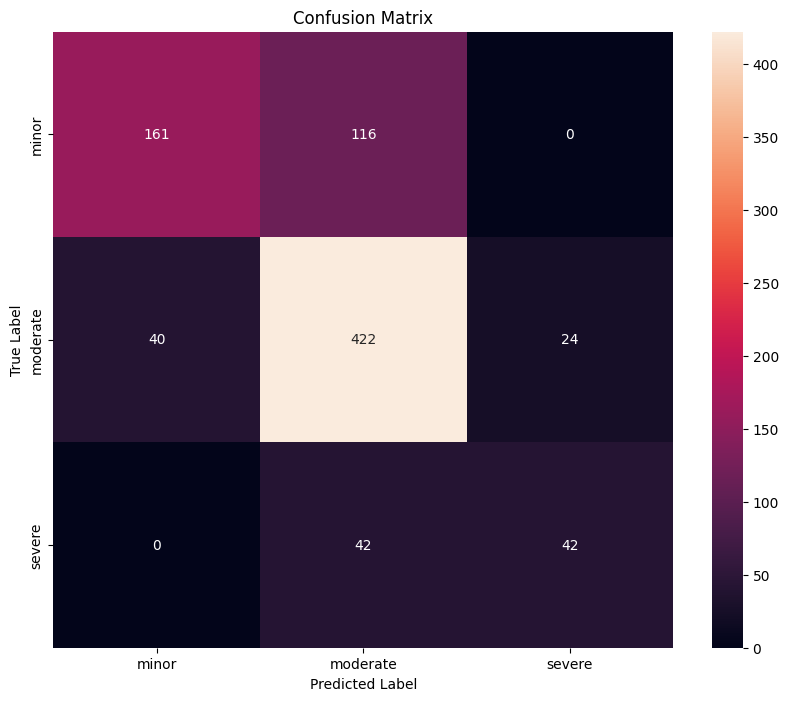

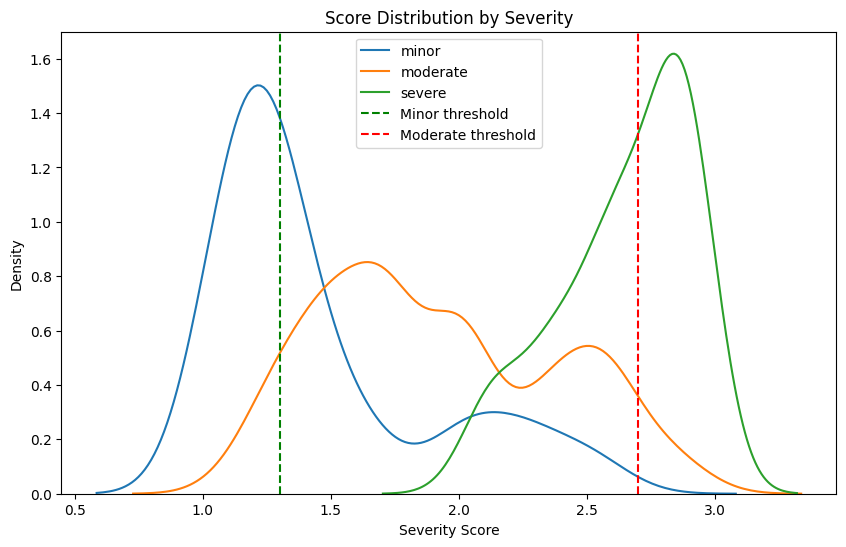

Batches: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


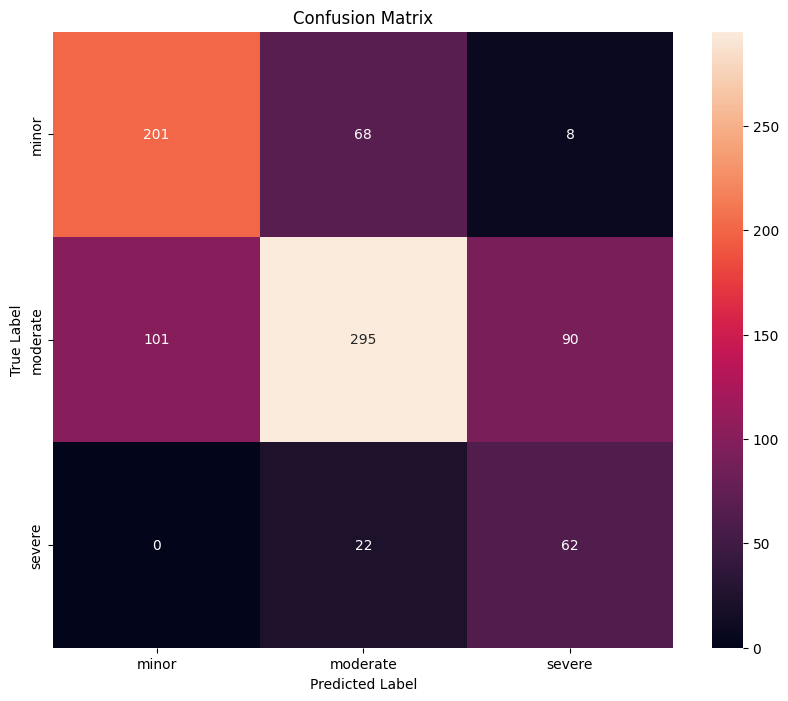

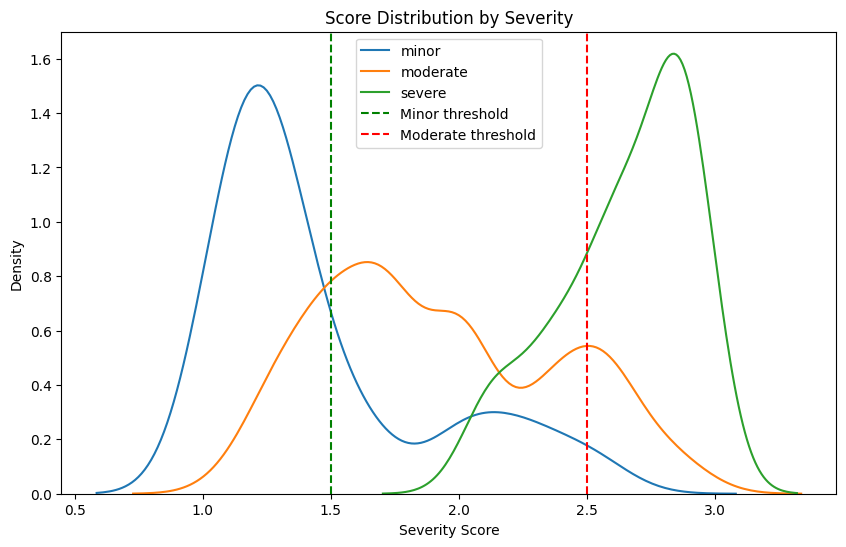

Batches: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%

In [8]:
optimal_thresholds = classifier.optimize_thresholds_fast()
eval_results = classifier.evaluate_thresholds(optimal_thresholds)

# You can also evaluate current thresholds
current_eval = classifier.evaluate_thresholds(classifier.thresholds)

# Evaluate again
eval_results = classifier.evaluate_performance(test_data)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 27/27 [00:08<00:00,  3.34it/s]
INFO:__main__:Loaded 847 incidents and created embeddings



Original Data Distribution:
Moderate: 486 (57.4%)
Minor: 277 (32.7%)
Severe: 84 (9.9%)

Training Data Distribution:
Moderate: 437 (57.3%)
Minor: 249 (32.7%)
Severe: 76 (10.0%)

Test Data Distribution:
Moderate: 49 (57.6%)
Minor: 28 (32.9%)
Severe: 8 (9.4%)

Training classifier...


Batches: 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]



Optimizing thresholds on training data...
Calculating severity scores...


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.68it/s]



MINOR scores:
Mean: 1.44
Std: 0.42
Range: [1.00, 2.67]

MODERATE scores:
Mean: 1.90
Std: 0.46
Range: [1.13, 2.94]

SEVERE scores:
Mean: 2.65
Std: 0.24
Range: [2.11, 3.00]

Testing threshold combinations...
Progress: 25/25 combinations

Optimization complete!
Best thresholds: {'minor': 1.4586552280153797, 'moderate': 2.5643895555987353}

Per-class performance with best thresholds:

MINOR:
Precision: 0.737
Recall: 0.719
F1-score: 0.728
Support: 249.0

MODERATE:
Precision: 0.789
Recall: 0.760
F1-score: 0.774
Support: 437.0

SEVERE:
Precision: 0.551
Recall: 0.711
F1-score: 0.621
Support: 76.0


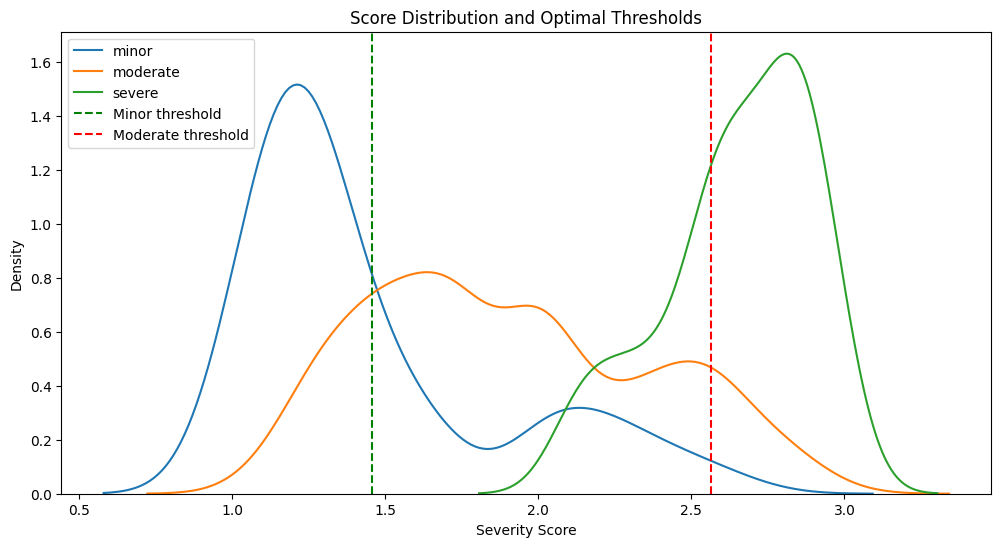


Evaluating on test data...


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 111.11it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 66.65it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
Batches: 100

TypeError: MaritimeSeverityClassifier.display_evaluation_results() takes 1 positional argument but 2 were given

In [15]:
# Initialize classifier
classifier = MaritimeSeverityClassifier()

# Load data
classifier.load_and_prepare_data('data/AStar_training_data.csv')

# Split data
train_df, test_df = classifier.prepare_train_test_split(test_size=0.1)

# Train and evaluate
results = classifier.train_and_evaluate(train_df, test_df)

# Display results
classifier.display_evaluation_results(results)

In [16]:
def display_evaluation_results(results: Dict):
    """
    Display evaluation results in a clear format
    """
    for method in ['original', 'optimized']:
        print(f"\n=== {method.upper()} THRESHOLDS ===")
        print(f"Thresholds: {results[method]['thresholds']}")
        print(f"Overall Accuracy: {results[method]['metrics']['accuracy']:.3f}")
        
        print("\nPer-class Performance:")
        for severity in ['minor', 'moderate', 'severe']:
            metrics = results[method]['metrics'].get(severity, {})
            if metrics:
                print(f"\n{severity.upper()}:")
                print(f"Precision: {metrics['precision']:.3f}")
                print(f"Recall: {metrics['recall']:.3f}")
                print(f"F1-score: {metrics['f1-score']:.3f}")
                print(f"Support: {metrics['support']}")
        
        print("\nConfusion Matrix:")
        cm = results[method]['confusion_matrix']
        print('\n'.join([''.join([f'{num:4}' for num in row]) for row in cm]))
display_evaluation_results(results)



=== ORIGINAL THRESHOLDS ===
Thresholds: {'minor': 1.7, 'moderate': 2.3}
Overall Accuracy: 0.565

Per-class Performance:

MINOR:
Precision: 0.488
Recall: 0.714
F1-score: 0.580
Support: 28.0

MODERATE:
Precision: 0.659
Recall: 0.551
F1-score: 0.600
Support: 49.0

SEVERE:
Precision: 0.333
Recall: 0.125
F1-score: 0.182
Support: 8.0

Confusion Matrix:
  20   8   0
  20  27   2
   1   6   1

=== OPTIMIZED THRESHOLDS ===
Thresholds: {'minor': 1.4586552280153797, 'moderate': 2.5643895555987353}
Overall Accuracy: 0.588

Per-class Performance:

MINOR:
Precision: 0.514
Recall: 0.679
F1-score: 0.585
Support: 28.0

MODERATE:
Precision: 0.667
Recall: 0.612
F1-score: 0.638
Support: 49.0

SEVERE:
Precision: 0.333
Recall: 0.125
F1-score: 0.182
Support: 8.0

Confusion Matrix:
  19   9   0
  17  30   2
   1   6   1


Maritime RAG Pipeline

In [24]:
from dataclasses import dataclass
from typing import List, Dict, Optional
import os
import requests
import re
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.chat_models import ChatAnthropic
from anthropic import Anthropic
@dataclass
class RiskAnalysisResult:
    """Comprehensive result from the maritime risk analysis pipeline"""
    # Input
    input_text: str
    source_url: Optional[str]
    
    # Classifications
    incident_categories: List[str]
    category_probabilities: Dict[str, float]
    severity_classification: Dict[str, any]
    
    # RAG Analysis
    impact_analysis: str
    mitigation_strategies: List[str]
    relevant_past_incidents: List[Dict[str, any]]
    
    # Metadata
    analysis_timestamp: str
    confidence_scores: Dict[str, float]
    model_versions: Dict[str, str]

In [25]:
class MaritimeRAGPipeline:
    def __init__(
        self, 
        persist_dir="./maritime_db", 
        model_name="all-MiniLM-L6-v2",
        severity_data_path="./historical_incidents.csv"
    ):
        """Initialize pipeline with vector store, severity classifier, and category classifier"""
        self.persist_dir = persist_dir
        self.embeddings = HuggingFaceEmbeddings(model_name=model_name)
        
        # Load existing vector store
        if not os.path.exists(persist_dir):
            raise Exception(f"Vector store not found at {persist_dir}. Please run data_loader.py first.")
        
        self.vector_store = Chroma(
            persist_directory=persist_dir,
            embedding_function=self.embeddings
        )
        
        # Initialize Anthropic client and custom LLM wrapper
        self.anthropic_client = Anthropic()
        self.llm = self.create_custom_llm()
        
        self.memory = ConversationBufferMemory(
            memory_key="chat_history",
            output_key="answer",
            return_messages=True
        )
        
        # Initialize classifiers
        self.category_classifier = MaritimeClassifier()
        self.severity_classifier = MaritimeSeverityClassifier(model_name=model_name)
        self.severity_classifier.load_and_prepare_data(severity_data_path)

    def create_custom_llm(self):
        """Create a custom LLM wrapper for Anthropic's Claude"""
        class CustomAnthropicLLM:
            def __init__(self, client):
                self.client = client

            def __call__(self, prompt):
                try:
                    response = self.client.messages.create(
                        model="claude-3-sonnet-20240229",
                        max_tokens=4096,
                        temperature=0.7,
                        messages=[{"role": "user", "content": prompt}]
                    )
                    return response.content[0].text
                except Exception as e:
                    print(f"Error in LLM call: {e}")
                    raise

        return CustomAnthropicLLM(self.anthropic_client)

    def create_enhanced_analysis_prompt(
        self, 
        query: str, 
        context_docs: str, 
        incident_categories: List[str],
        severity_result: Dict
    ) -> str:
        """Create analysis prompt incorporating both classification and severity results"""
        categories_text = "\n".join([f"- {cat}" for cat in incident_categories])
        
        # Extract severity information
        severity_level = severity_result['classification']['severity']
        key_factors = "\n".join([f"- {factor}" for factor in severity_result['classification']['key_factors']])
        similar_incidents = "\n".join([
            f"- {inc['headline']} (Severity: {inc['severity']}, Similarity: {inc['similarity']:.2f})"
            for inc in severity_result['evidence']['similar_incidents'][:3]
        ])

        return f"""You are a maritime safety expert analyzing incidents. Use the provided context, classifications, and severity assessment to inform your analysis.

        Incident Severity: {severity_level.upper()}
        Confidence: {severity_result['classification']['confidence']}
        
        Key Factors in Severity Assessment:
        {key_factors}
        
        Similar Historical Incidents:
        {similar_incidents}

        Detected Incident Categories:
        {categories_text}

        Context from Knowledge Base:
        {context_docs}

        Current incident:
        {query}

        Provide a structured analysis in the following format:

        1. Severity-Based Impact Assessment
        - Safety Impacts (Score __/5):
            [Analyze based on {severity_level} severity classification]
        - Environmental Impacts (Score __/5):
            [Consider severity level and similar incidents]
        - Economic Impacts (Score __/5):
            [Analyze financial implications given severity]
        - Navigational Impacts (Score __/5):
            [Assess operational disruption level]
            
        2. Category-Specific Analysis
        [Analyze implications specific to each detected category, considering severity level]

        3. Risk-Adjusted Mitigation Strategies
        - Immediate Response:
            [Prioritize based on {severity_level} severity]
        - Prevention Measures:
            [Long-term strategies considering similar incidents]
        - Enhanced Safety Protocols:
            [Specific to severity level and categories]
        - Equipment & Resource Requirements:
            [Based on severity classification]
        - Category-Specific Mitigations:
            [Tailored to each category and severity level]

        Base your analysis on the severity classification, incident categories, and historical context.
        For each point, cite specific examples using [Source X] notation and explain how the severity level influences the recommended actions."""

    @dataclass
    class MaritimeAnalysisResult:
        """Enhanced result including severity classification"""
        impact_analysis: str
        mitigation_strategies: str
        source_documents: List[str]
        similarity_scores: List[float]
        incident_categories: List[str]
        category_probabilities: Dict[str, float]
        severity_classification: Dict
        average_impact_score: float


    def analyze_incident(self, query: str, k: int = 5) -> MaritimeAnalysisResult:
        """Analyze maritime incident with integrated severity and category classification"""
        try:
            # Check if query is a URL and scrape if necessary
            if query.startswith('http'):
                query = self.scrape_article(query)

            # Get both classification results
            incident_categories, category_probs = self.category_classifier.predict(query)
            severity_result = self.severity_classifier.classify_severity(query)
            
            # Get relevant documents
            relevant_docs = self.vector_store.similarity_search_with_score(query, k=k)
            docs = [doc[0] for doc in relevant_docs]
            scores = [score[1] for score in relevant_docs]
            
            # Combine document content
            context = "\n\n".join([f"[Source {i+1}]: {doc.page_content}" 
                                for i, doc in enumerate(docs)])

            # Create the prompt
            prompt = self.create_enhanced_analysis_prompt(
                query, 
                context, 
                incident_categories,
                severity_result
            )

            # Generate analysis directly using Anthropic client
            response = self.anthropic_client.messages.create(
                model="claude-3-sonnet-20240229",
                max_tokens=4096,
                temperature=0.7,
                messages=[{"role": "user", "content": prompt}]
            )
            
            analysis_text = response.content[0].text
            
            # Parse impact scores from the response
            impact_scores = self._extract_impact_scores(analysis_text)
            
            # Split response into sections
            try:
                parts = analysis_text.split("3. Risk-Adjusted Mitigation")
                if len(parts) == 2:
                    impact_analysis = parts[0]
                    mitigation_strategies = "3. Risk-Adjusted Mitigation" + parts[1]
                else:
                    impact_analysis = analysis_text
                    mitigation_strategies = ""
            except Exception as e:
                print(f"Warning: Error splitting response: {e}")
                impact_analysis = analysis_text
                mitigation_strategies = ""

            return self.MaritimeAnalysisResult(
                impact_analysis=impact_analysis.strip(),
                mitigation_strategies=mitigation_strategies.strip(),
                source_documents=[f"[Source {i+1}]: {doc.metadata.get('source', 'Unknown')}"
                                for i, doc in enumerate(docs)],
                similarity_scores=scores,
                incident_categories=incident_categories,
                category_probabilities=category_probs,
                severity_classification=severity_result,
                average_impact_score=impact_scores['average']
            )
        except Exception as e:
            print(f"Error in analyze_incident: {e}")
            raise

    def _extract_impact_scores(self, response: str) -> Dict[str, float]:
        """Extract impact scores from the analysis response"""
        import re
        
        scores = {
            'safety': 0.0,
            'environmental': 0.0,
            'economic': 0.0,
            'navigational': 0.0
        }
        
        # Extract scores using regex
        score_pattern = r"(\w+) Impacts \(Score (\d+)/5\)"
        matches = re.finditer(score_pattern, response)
        
        for match in matches:
            category = match.group(1).lower()
            score = float(match.group(2))
            if category in scores:
                scores[category] = score
        
        # Calculate average
        scores['average'] = sum(scores.values()) / len(scores) if scores else 0
        
        return scores

    def process_url_query(self, url: str) -> EnhancedAnalysisResult:
        """Process article URL as query"""
        try:
            print(f"Scraping content from: {url}")
            article_content = self.scrape_article(url)
            if not article_content:
                raise ValueError("No content retrieved from URL")
            return self.analyze_incident(article_content)
        except Exception as e:
            print(f"Error processing URL: {e}")
            raise

    def scrape_article(self, url: str) -> str:
        """Scrape article using jina.ai"""
        jina_url = f"https://r.jina.ai/{url}"
        response = requests.get(jina_url)
        if response.status_code == 200:
            return response.text
        else:
            raise Exception(f"Failed to scrape article: {response.status_code}")

In [26]:
# Initialize
pipeline =MaritimeRAGPipeline(
    persist_dir="./maritime_db",
    severity_data_path="data/AStar_training_data.csv"
)

# Analyze incident
result = pipeline.analyze_incident("https://www.seatrade-maritime.com/accidents/maersk-container-vessel-smashes-iconic-tall-ship-leeuwin")

# Access results
print(f"Severity: {result.severity_classification['classification']['severity']}")
print(f"Average Impact Score: {result.average_impact_score}")
print(f"Categories: {result.incident_categories}")
print(result.impact_analysis)
print(result.mitigation_strategies)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


All classification models loaded successfully


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 27/27 [00:08<00:00,  3.29it/s]
INFO:__main__:Loaded 847 incidents and created embeddings
Batches: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Severity: severe
Average Impact Score: 4.0
Categories: ['level 3: Maritime cargo and ship detainment', 'level 4: Maritime environmental impacts and pollution', 'level 8: Vessel delay']
Here is a structured analysis based on the provided context:

1. Severity-Based Impact Assessment

- Safety Impacts (Score 5/5):
    The complete destruction of the historic tall ship Leeuwin and damage to the Leeuwin II sailing vessel, along with injuries to two crew members, indicate severe safety impacts. [Source 1] Given the "SEVERE" incident severity classification, maritime safety was severely compromised, necessitating an in-depth investigation into the causes and preventive measures.

- Environmental Impacts (Score 4/5):  
    While no direct environmental pollution is mentioned, the involvement of a major container ship and a sailing vessel raises concerns about potential fuel/oil spills or debris in the water. The "Maritime environmental impacts and pollution" category [Source 1] suggests possi